#Topic Modeling 

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
nltk.download('stopwords')
import os
import operator 
import re
import sys

import seaborn as sns
from Proccess import create_text_column

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swcam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
pd.set_option('display.width', 1000) # Expands the width of the dataframe

In [4]:
#Preprocossing 

In [5]:
url_df = pd.read_csv(r"\Users\swcam\Desktop\Data\Fixed_data\aug_2014_tweets.csv",engine='python', encoding='utf-8',error_bad_lines=False) 
url_df.head(3)

,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54
0,https://twitter.com/ORMultimedios/status/49822...,2014-08-09 21:50:18+00:00,#AlMomento #PolicíasComunitarios y normalistas...,#AlMomento #PolicíasComunitarios y normalistas...,4.982250e+17,"{'username': 'ORMultimedios', 'displayname': '...",['http://ow.ly/i/6vu6a'],['http://t.co/Rea7WTZ5xD'],0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://twitter.com/CCSPJP/status/498218246709...,2014-08-09 21:24:21+00:00,Policías comunitarios y normalistas de Ayotzin...,Policías comunitarios y normalistas de Ayotzin...,4.982180e+17,"{'username': 'CCSPJP', 'displayname': 'CCSPJP'...",[],[],1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://twitter.com/JuanC__Castillo/status/498...,2014-08-09 21:14:49+00:00,Reforma informa: Protestan contra Aguirre en G...,Reforma informa: Protestan contra Aguirre en G...,4.982160e+17,"{'username': 'JuanC__Castillo', 'displayname':...",['http://ow.ly/2LvhNI'],['http://t.co/PCfwrFEGDZ'],0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
##Preprocess Data
text_df = create_text_column(url_df)
complete_df = text_df


In [7]:
complete_df.shape

(145, 57)

In [8]:
data = complete_df.copy()

In [9]:
data.shape

(145, 57)

In [10]:
# convert to Disinformation dataframe (only text labeled as disinformation by the model)

new_df = data.copy()

In [11]:
new_df.head()

,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,proc_text,tok_text
0,https://twitter.com/ORMultimedios/status/49822...,2014-08-09 21:50:18+00:00,#AlMomento #PolicíasComunitarios y normalistas...,#AlMomento #PolicíasComunitarios y normalistas...,4.982250e+17,"{'username': 'ORMultimedios', 'displayname': '...",['http://ow.ly/i/6vu6a'],['http://t.co/Rea7WTZ5xD'],0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,y normalistas irrumpen acto y protestan contra...,"[normalistas, irrumpen, acto, protestan, gober..."
1,https://twitter.com/CCSPJP/status/498218246709...,2014-08-09 21:24:21+00:00,Policías comunitarios y normalistas de Ayotzin...,Policías comunitarios y normalistas de Ayotzin...,4.982180e+17,"{'username': 'CCSPJP', 'displayname': 'CCSPJP'...",[],[],1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Policas comunitarios y normalistas de Ayotzina...,"[Policas, comunitarios, normalistas, Ayotzinap..."
2,https://twitter.com/JuanC__Castillo/status/498...,2014-08-09 21:14:49+00:00,Reforma informa: Protestan contra Aguirre en G...,Reforma informa: Protestan contra Aguirre en G...,4.982160e+17,"{'username': 'JuanC__Castillo', 'displayname':...",['http://ow.ly/2LvhNI'],['http://t.co/PCfwrFEGDZ'],0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reforma informa: Protestan contra Aguirre en G...,"[Reforma, informa, :, Protestan, Aguirre, Guer..."
3,https://twitter.com/AnitaHVVerde/status/498210...,2014-08-09 20:54:38+00:00,Protestan contra Aguirre en Guerrero: Policías...,Protestan contra Aguirre en Guerrero: Policías...,4.982110e+17,"{'username': 'AnitaHVVerde', 'displayname': 'A...",['http://bit.ly/1rbHf8m'],['http://t.co/HvLmh9wKZX'],0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Protestan contra Aguirre en Guerrero: Policas ...,"[Protestan, Aguirre, Guerrero, :, Policas, com..."
4,https://twitter.com/negroniNSt/status/49821076...,2014-08-09 20:54:38+00:00,Protestan contra Aguirre en Guerrero: Policías...,Protestan contra Aguirre en Guerrero: Policías...,4.982110e+17,"{'username': 'negroniNSt', 'displayname': 'Agu...",['http://bit.ly/1rbHf8m'],['http://t.co/oy196JqY93'],0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Protestan contra Aguirre en Guerrero: Policas ...,"[Protestan, Aguirre, Guerrero, :, Policas, com..."


In [12]:
new_df.dtypes

url                 object
date                object
content             object
renderedContent     object
id                 float64
user                object
outlinks            object
tcooutlinks         object
replyCount           int64
retweetCount         int64
likeCount            int64
quoteCount           int64
conversationId     float64
lang                object
source              object
sourceUrl           object
sourceLabel         object
media               object
retweetedTweet     float64
quotedTweet        float64
mentionedUsers      object
Unnamed: 21        float64
Unnamed: 22        float64
Unnamed: 23        float64
Unnamed: 24        float64
Unnamed: 25        float64
Unnamed: 26        float64
Unnamed: 27        float64
Unnamed: 28        float64
Unnamed: 29        float64
Unnamed: 30        float64
Unnamed: 31        float64
Unnamed: 32        float64
Unnamed: 33        float64
Unnamed: 34        float64
Unnamed: 35        float64
Unnamed: 36        float64
U

Prepare stop words

In [13]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')

In [14]:
data= new_df['tok_text'].tolist()


Preprocessing 

Tokenize words and Clean-up text

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['normalistas', 'irrumpen', 'acto', 'protestan', 'gobernador']]


Creating Bigram and Trigram Models

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['normalistas', 'irrumpen', 'acto', 'protestan', 'gobernador']


 Remove Stopwords, Make Bigrams and Lemmatize

In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('es_core_news_md', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['normalista', 'irrumpir', 'acto', 'protestar', 'gobernador']]


Create the Dictionary and Corpus needed for Topic Modeling

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


Building the Topic Model

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [20]:
# Build LDA model (set desired number of topics here)

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.147*"estrella" + 0.074*"ayotzinapa" + 0.072*"oro" + 0.054*"autobs" + '
  '0.037*"robaron" + 0.037*"atrs" + 0.035*"estudiantes" + 0.019*"interesa" + '
  '0.019*"compaeros" + 0.019*"estan"'),
 (1,
  '0.105*"rosas" + 0.105*"facundo" + 0.095*"comparece" + 0.090*"ayotzinapa" + '
  '0.083*"viol" + 0.082*"chalchihuapan" + 0.081*"cndh" + 0.071*"humanos" + '
  '0.071*"derechos" + 0.065*"ahora"'),
 (2,
  '0.254*"normal" + 0.163*"ayotzinapa" + 0.079*"escuela" + 0.022*"estudiantes" '
  '+ 0.020*"cuenta" + 0.020*"represin" + 0.020*"nueva" + 0.020*"detenidos" + '
  '0.002*"rural" + 0.002*"reunin"'),
 (3,
  '0.328*"ayotzinapa" + 0.322*"congreso" + 0.232*"social" + 0.034*"caso" + '
  '0.003*"diputado" + 0.003*"versin" + 0.003*"discrepancias" + 0.003*"oficial" '
  '+ 0.000*"fuertes" + 0.000*"acuerdos"'),
 (4,
  '0.075*"ayotzinapa" + 0.040*"seis" + 0.040*"detiene" + 0.040*"pgr" + '
  '0.040*"alumnos" + 0.040*"trasladados" + 0.040*"delegacin" + 0.034*"ayer" + '
  '0.034*"la" + 0.034*"dos"'),
 (

Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.530423025425079

Coherence Score:  0.31732030106281617


How to find the optimal number of topics for LDA?

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

C:\Users\swcam\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\swcam\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


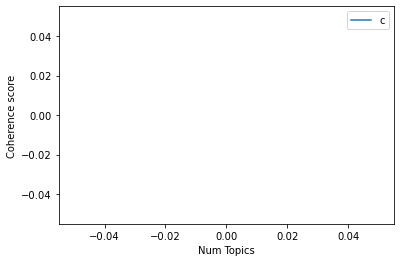

In [25]:
import matplotlib.pyplot as plt

# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of nan
Num Topics = 8  has Coherence Value of nan
Num Topics = 14  has Coherence Value of nan
Num Topics = 20  has Coherence Value of nan
Num Topics = 26  has Coherence Value of nan
Num Topics = 32  has Coherence Value of nan
Num Topics = 38  has Coherence Value of nan


Choose the optimal model. In this case it is model with index number of 6(Num Topics = 38)

In [27]:
# Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(7,
  '0.053*"robar" + 0.053*"seis" + 0.053*"trasladados" + 0.053*"alumnos" + '
  '0.053*"delegacin" + 0.053*"chilpo" + 0.053*"detiene" + 0.053*"pgr" + '
  '0.053*"autobus" + 0.053*"ayotzinapa"'),
 (14,
  '0.087*"ayotzinapa" + 0.069*"ahora" + 0.069*"cndh" + 0.069*"facundo" + '
  '0.069*"rosas" + 0.035*"derechos" + 0.035*"viol" + 0.035*"comparece" + '
  '0.035*"historia" + 0.035*"puebla"'),
 (23,
  '0.081*"gober" + 0.081*"ayotzinapa" + 0.041*"precioso" + 0.041*"amigos" + '
  '0.041*"luisgarca" + 0.041*"autopistadelsol" + 0.041*"apoyo" + '
  '0.041*"poblanos" + 0.041*"comparezcan" + 0.041*"pasa"'),
 (8,
  '0.097*"ayotzinapa" + 0.039*"duraderos" + 0.039*"comunitarios" + '
  '0.039*"protestan" + 0.039*"social" + 0.039*"fuertes" + 0.039*"aguirre" + '
  '0.039*"normalistas" + 0.039*"congreso" + 0.039*"protestaron"'),
 (34,
  '0.079*"sabado" + 0.079*"social" + 0.079*"domingo" + 0.079*"congreso" + '
  '0.079*"prximos" + 0.079*"ayotzinapa" + 0.002*"estudiantil" + 0.002*"citado" '
  '+ 0.002*"f

Find dominant topic in each sentence 

In [28]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,22.0,0.8377,"ayotzinapa, historia, facundo, cndh, responde,...","[normalistas, irrumpen, acto, protestan, gober..."
1,1,10.0,0.8377,"ayotzinapa, normalistas, protestan, aguirre, c...","[Policas, comunitarios, normalistas, Ayotzinap..."
2,2,16.0,0.9115,"ayotzinapa, puebla, rosas, facundo, normalista...","[Reforma, informa, :, Protestan, Aguirre, Guer..."
3,3,10.0,0.8918,"ayotzinapa, normalistas, protestan, aguirre, c...","[Protestan, Aguirre, Guerrero, :, Policas, com..."
4,4,10.0,0.8918,"ayotzinapa, normalistas, protestan, aguirre, c...","[Protestan, Aguirre, Guerrero, :, Policas, com..."
5,5,10.0,0.8918,"ayotzinapa, normalistas, protestan, aguirre, c...","[Protestan, Aguirre, Guerrero, :, Policas, com..."
6,6,10.0,0.8918,"ayotzinapa, normalistas, protestan, aguirre, c...","[Protestan, Aguirre, Guerrero, :, Policas, com..."
7,7,10.0,0.8918,"ayotzinapa, normalistas, protestan, aguirre, c...","[Protestan, Aguirre, Guerrero, :, Policas, com..."
8,8,10.0,0.8918,"ayotzinapa, normalistas, protestan, aguirre, c...","[Protestan, Aguirre, Guerrero, :, Policas, com..."
9,9,10.0,0.8918,"ayotzinapa, normalistas, protestan, aguirre, c...","[Protestan, Aguirre, Guerrero, :, Policas, com..."


Find the most representative document for each topic

In [29]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)



In [30]:
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(38)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9115,"ayotzinapa, congreso, castigue, en, ya, el, pe...","[Este, perro, rabioso, FaCANdo, ,, YA, HABA, A..."
1,1.0,0.9115,"ayotzinapa, autobs, turstico, social, congreso...","[Interesante, ejercido, facultad, investigacin..."
2,2.0,0.9115,"ayotzinapa, cndh, ahora, facundo, rosas, chalc...","[:, Facundo, Rosas, comparece, CNDH, ahora, Ch..."
3,3.0,0.9026,"ayotzinapa, cndh, propia, ahora, facundo, repi...","[Reunin, egresados, escuela, Normal, Rural, ``..."
4,5.0,0.9115,"facundo, ayotzinapa, cndh, rosas, vctor, felip...","[Felipe, Caldern, ,, CNDH, ,, Facundo, Rosas, ..."
5,6.0,0.9189,"ayotzinapa, autobs, oro, comparece, secuestran...","[:, No, primera, vez, Facundo, Rosas, comparec..."
6,7.0,0.9189,"robar, seis, trasladados, alumnos, delegacin, ...","[La, noche, ayer, detenidos, normalistas, ,, t..."
7,8.0,0.9026,"ayotzinapa, duraderos, comunitarios, protestan...","[Facundo, Rosas, comparece, represin, ;, tambi..."
8,10.0,0.9115,"ayotzinapa, normalistas, protestan, aguirre, c...","[Denuncia, Tlachinollan, criminalizacin, CRAC,..."
9,12.0,0.9115,"ayotzinapa, domingo, el, social, sbado, cndh, ...","[., El, Congreso, Social, Ayotzinapa, celebrar..."


In [31]:
combo = complete_df.rename(columns = {'tok_text': 'Text'})  ##Turns column to Text so that I can match later

In [32]:
combo.dtypes

url                 object
date                object
content             object
renderedContent     object
id                 float64
user                object
outlinks            object
tcooutlinks         object
replyCount           int64
retweetCount         int64
likeCount            int64
quoteCount           int64
conversationId     float64
lang                object
source              object
sourceUrl           object
sourceLabel         object
media               object
retweetedTweet     float64
quotedTweet        float64
mentionedUsers      object
Unnamed: 21        float64
Unnamed: 22        float64
Unnamed: 23        float64
Unnamed: 24        float64
Unnamed: 25        float64
Unnamed: 26        float64
Unnamed: 27        float64
Unnamed: 28        float64
Unnamed: 29        float64
Unnamed: 30        float64
Unnamed: 31        float64
Unnamed: 32        float64
Unnamed: 33        float64
Unnamed: 34        float64
Unnamed: 35        float64
Unnamed: 36        float64
U

In [33]:
sent_topics_sorteddf_mallet.dtypes

Topic_Num             float64
Topic_Perc_Contrib    float64
Keywords               object
Text                   object
dtype: object

In [34]:
combo2 = new_df.rename(columns = {'tok_text': 'Text'})  ##Turns column to Text so that I can match latertok_text 

In [35]:
combo2['liststring'] = combo2['Text'].apply(lambda x: ','.join(map(str, x)))

In [36]:
combo1 = sent_topics_sorteddf_mallet.copy()
combo1['liststring'] = combo1['Text'].apply(lambda x: ','.join(map(str, x)))

In [37]:
combo1.dtypes

Topic_Num             float64
Topic_Perc_Contrib    float64
Keywords               object
Text                   object
liststring             object
dtype: object

In [38]:
merged = pd.merge(combo1, combo2, on =['liststring'], how='inner')  ##Does an inner merge

In [39]:
merged.head(30)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text_x,liststring,url,date,content,renderedContent,id,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,proc_text,Text_y
0,0.0,0.9115,"ayotzinapa, congreso, castigue, en, ya, el, pe...","[Este, perro, rabioso, FaCANdo, ,, YA, HABA, A...","Este,perro,rabioso,FaCANdo,,,YA,HABA,ASESINADO...",https://twitter.com/zame47/status/497563506447...,2014-08-08 02:02:38+00:00,"Este perro rabioso FaCANdo, YA HABÍA ASESINADO...","Este perro rabioso FaCANdo, YA HABÍA ASESINADO...",4.975640e+17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Este perro rabioso FaCANdo, YA HABA ASESINADO ...","[Este, perro, rabioso, FaCANdo, ,, YA, HABA, A..."
1,1.0,0.9115,"ayotzinapa, autobs, turstico, social, congreso...","[Interesante, ejercido, facultad, investigacin...","Interesante,ejercido,facultad,investigacin,cas...",https://twitter.com/TavoAmezcua/status/4949991...,2014-08-01 00:12:46+00:00,Interesante que la @CNDH haya ejercido esta fa...,Interesante que la @CNDH haya ejercido esta fa...,4.949990e+17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Interesante que la haya ejercido esta facultad...,"[Interesante, ejercido, facultad, investigacin..."
2,2.0,0.9115,"ayotzinapa, cndh, ahora, facundo, rosas, chalc...","[:, Facundo, Rosas, comparece, CNDH, ahora, Ch...",":,Facundo,Rosas,comparece,CNDH,ahora,Chalchihu...",https://twitter.com/lospetirrojos/status/49700...,2014-08-06 12:44:52+00:00,#Guanajuato: Facundo Rosas comparece ante CND...,#Guanajuato: Facundo Rosas comparece ante CND...,4.970000e+17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,: Facundo Rosas comparece ante CNDH ahora por ...,"[:, Facundo, Rosas, comparece, CNDH, ahora, Ch..."
3,3.0,0.9026,"ayotzinapa, cndh, propia, ahora, facundo, repi...","[Reunin, egresados, escuela, Normal, Rural, ``...","Reunin,egresados,escuela,Normal,Rural,``,Ral,I...",https://twitter.com/silviaromeroDip/status/500...,2014-08-16 01:36:14+00:00,Reunión con egresados de la escuela Normal Rur...,Reunión con egresados de la escuela Normal Rur...,5.000000e+17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reunin con egresados de la escuela Normal Rura...,"[Reunin, egresados, escuela, Normal, Rural, ``..."
4,5.0,0.9115,"facundo, ayotzinapa, cndh, rosas, vctor, felip...","[Felipe, Caldern, ,, CNDH, ,, Facundo, Rosas, ...","Felipe,Caldern,,,CNDH,,,Facundo,Rosas,,,Ayotzi...",https://twitter.com/VladRothschuh/status/49704...,2014-08-06 15:47:17+00:00,"Felipe Calderón, CNDH, Facundo Rosas, Ayotzina...","Felipe Calderón, CNDH, Facundo Rosas, Ayotzina...",4.970460e+17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Felipe Caldern, CNDH, Facundo Rosas, Ayotzinap...","[Felipe, Caldern, ,, CNDH, ,, Facundo, Rosas, ..."
5,6.0,0.9189,"ayotzinapa, autobs, oro, comparece, secuestran...","[:, No, primera, vez, Facundo, Rosas, comparec...",":,No,primera,vez,Facundo,Rosas,comparece,CNDH,...",https://twitter.com/PacoSanz9/status/497019616...,2014-08-06 14:01:25+00:00,“@SinEmbargoMX: No es la primera vez que Facun...,“@SinEmbargoMX: No es la primera vez que Facun...,4.970200e+17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,: No es la primera vez que Facundo Rosas compa...,"[:, No, primera, vez, Facundo, Rosas, comparec..."
6,7.0,0.9189,"robar, seis, trasladados, alumnos, delegacin, ...","[La, noche, ayer, detenidos, normalistas, ,, t...","La,noche,ayer,detenidos,normalistas,,,tras,ret...",https://twitter.com/ReporTorres/status/4966999...,2014-08-05 16:51:16+00:00,La noche de ayer fueron detenidos 6 normalista...,La noche de ayer fueron detenidos 6 normalista...,4.967000e+17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,La noche de ayer fueron detenidos normalistas ...,"[La, noche, ayer, detenidos, normalistas, ,, t..."
7,8.0,0.9026,"ayotzinapa, duraderos, comunitarios, protestan...","[Facundo, Rosas, comparece, represin, ;, tambi...","Facundo,Rosas,comparece,represin,;,tambin,viol...",https://twitter.com/NOTIGODINEZ/status/4970053...,2014-08-06 13:04:46+00:00,Facundo Rosas comparece ante #CNDH por represi...,Facundo Rosas

In [40]:
merged.shape

(36, 62)

In [41]:
merged.drop_duplicates('Keywords', keep='first', inplace=True)  # Gets rid of ducplicates

In [42]:
merged.shape

(31, 62)

In [43]:
merged = merged.loc[:, ~merged.columns.str.contains('^Unnamed')]  ## Gets rid of Unnamed columns

In [44]:
merged.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text_x,liststring,url,date,content,renderedContent,id,...,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers,proc_text,Text_y
0,0.0,0.9115,"ayotzinapa, congreso, castigue, en, ya, el, pe...","[Este, perro, rabioso, FaCANdo, ,, YA, HABA, A...","Este,perro,rabioso,FaCANdo,,,YA,HABA,ASESINADO...",https://twitter.com/zame47/status/497563506447...,2014-08-08 02:02:38+00:00,"Este perro rabioso FaCANdo, YA HABÍA ASESINADO...","Este perro rabioso FaCANdo, YA HABÍA ASESINADO...",4.975640e+17,...,es,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://twitter.com,Twitter Web Client,NaN,NaN,NaN,NaN,"Este perro rabioso FaCANdo, YA HABA ASESINADO ...","[Este, perro, rabioso, FaCANdo, ,, YA, HABA, A..."
1,1.0,0.9115,"ayotzinapa, autobs, turstico, social, congreso...","[Interesante, ejercido, facultad, investigacin...","Interesante,ejercido,facultad,investigacin,cas...",https://twitter.com/TavoAmezcua/status/4949991...,2014-08-01 00:12:46+00:00,Interesante que la @CNDH haya ejercido esta fa...,Interesante que la @CNDH haya ejercido esta fa...,4.949990e+17,...,es,"<a href=""http://tapbots.com/tweetbot"" rel=""nof...",http://tapbots.com/tweetbot,Tweetbot for iΟS,NaN,NaN,NaN,"[{'username': 'CNDH', 'displayname': 'CNDH en ...",Interesante que la haya ejercido esta facultad...,"[Interesante, ejercido, facultad, investigacin..."
2,2.0,0.9115,"ayotzinapa, cndh, ahora, facundo, rosas, chalc...","[:, Facundo, Rosas, comparece, CNDH, ahora, Ch...",":,Facundo,Rosas,comparece,CNDH,ahora,Chalchihu...",https://twitter.com/lospetirrojos/status/49700...,2014-08-06 12:44:52+00:00,#Guanajuato: Facundo Rosas comparece ante CND...,#Guanajuato: Facundo Rosas comparece ante CND...,4.970000e+17,...,es,"<a href=""https://dlvrit.com/"" rel=""nofollow"">d...",https://dlvrit.com/,dlvr.it,NaN,NaN,NaN,NaN,: Facundo Rosas comparece ante CNDH ahora por ...,"[:, Facundo, Rosas, comparece, CNDH, ahora, Ch..."
3,3.0,0.9026,"ayotzinapa, cndh, propia, ahora, facundo, repi...","[Reunin, egresados, escuela, Normal, Rural, ``...","Reunin,egresados,escuela,Normal,Rural,``,Ral,I...",https://twitter.com/silviaromeroDip/status/500...,2014-08-16 01:36:14+00:00,Reunión con egresados de la escuela Normal Rur...,Reunión con egresados de la escuela Normal Rur...,5.000000e+17,...,es,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,[{'previewUrl': 'https://pbs.twimg.com/media/B...,NaN,NaN,NaN,Reunin con egresados de la escuela Normal Rura...,"[Reunin, egresados, escuela, Normal, Rural, ``..."
4,5.0,0.9115,"facundo, ayotzinapa, cndh, rosas, vctor, felip...","[Felipe, Caldern, ,, CNDH, ,, Facundo, Rosas, ...","Felipe,Caldern,,,CNDH,,,Facundo,Rosas,,,Ayotzi...",https://twitter.com/VladRothschuh/status/49704...,2014-08-06 15:47:17+00:00,"Felipe Calderón, CNDH, Facundo Rosas, Ayotzina...","Felipe Calderón, CNDH, Facundo Rosas, Ayotzina...",4.970460e+17,...,es,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",http://www.hootsuite.com,Hootsuite,NaN,NaN,NaN,NaN,"Felipe Caldern, CNDH, Facundo Rosas, Ayotzinap...","[Felipe, Caldern, ,, CNDH, ,, Facundo, Rosas, ..."


In [45]:
merged.columns

Index(['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Text_x', 'liststring', 'url', 'date', 'content', 'renderedContent', 'id', 'user', 'outlinks', 'tcooutlinks', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount', 'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel', 'media', 'retweetedTweet', 'quotedTweet', 'mentionedUsers', 'proc_text', 'Text_y'], dtype='object')

In [46]:
merged.drop(['renderedContent', 'id', 'user', 'outlinks', 'tcooutlinks', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount', 'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel', 'media', 'retweetedTweet', 'quotedTweet', 'mentionedUsers','liststring','Text_y'], axis=1)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text_x,url,date,content,proc_text
0,0.0,0.9115,"ayotzinapa, congreso, castigue, en, ya, el, pe...","[Este, perro, rabioso, FaCANdo, ,, YA, HABA, A...",https://twitter.com/zame47/status/497563506447...,2014-08-08 02:02:38+00:00,"Este perro rabioso FaCANdo, YA HABÍA ASESINADO...","Este perro rabioso FaCANdo, YA HABA ASESINADO ..."
1,1.0,0.9115,"ayotzinapa, autobs, turstico, social, congreso...","[Interesante, ejercido, facultad, investigacin...",https://twitter.com/TavoAmezcua/status/4949991...,2014-08-01 00:12:46+00:00,Interesante que la @CNDH haya ejercido esta fa...,Interesante que la haya ejercido esta facultad...
2,2.0,0.9115,"ayotzinapa, cndh, ahora, facundo, rosas, chalc...","[:, Facundo, Rosas, comparece, CNDH, ahora, Ch...",https://twitter.com/lospetirrojos/status/49700...,2014-08-06 12:44:52+00:00,#Guanajuato: Facundo Rosas comparece ante CND...,: Facundo Rosas comparece ante CNDH ahora por ...
3,3.0,0.9026,"ayotzinapa, cndh, propia, ahora, facundo, repi...","[Reunin, egresados, escuela, Normal, Rural, ``...",https://twitter.com/silviaromeroDip/status/500...,2014-08-16 01:36:14+00:00,Reunión con egresados de la escuela Normal Rur...,Reunin con egresados de la escuela Normal Rura...
4,5.0,0.9115,"facundo, ayotzinapa, cndh, rosas, vctor, felip...","[Felipe, Caldern, ,, CNDH, ,, Facundo, Rosas, ...",https://twitter.com/VladRothschuh/status/49704...,2014-08-06 15:47:17+00:00,"Felipe Calderón, CNDH, Facundo Rosas, Ayotzina...","Felipe Caldern, CNDH, Facundo Rosas, Ayotzinap..."
5,6.0,0.9189,"ayotzinapa, autobs, oro, comparece, secuestran...","[:, No, primera, vez, Facundo, Rosas, comparec...",https://twitter.com/PacoSanz9/status/497019616...,2014-08-06 14:01:25+00:00,“@SinEmbargoMX: No es la primera vez que Facun...,: No es la primera vez que Facundo Rosas compa...
6,7.0,0.9189,"robar, seis, trasladados, alumnos, delegacin, ...","[La, noche, ayer, detenidos, normalistas, ,, t...",https://twitter.com/ReporTorres/status/4966999...,2014-08-05 16:51:16+00:00,La noche de ayer fueron detenidos 6 normalista...,La noche de ayer fueron detenidos normalistas ...
7,8.0,0.9026,"ayotzinapa, duraderos, comunitarios, protestan...","[Facundo, Rosas, comparece, represin, ;, tambi...",https://twitter.com/NOTIGODINEZ/status/4970053...,2014-08-06 13:04:46+00:00,Facundo Rosas comparece ante #CNDH por represi...,Facundo Rosas comparece ante por represin en ;...
8,10.0,0.9115,"ayotzinapa, normalistas, protestan, aguirre, c...","[Denuncia, Tlachinollan, criminalizacin, CRAC,...",https://twitter.com/CctiColectivo/status/49923...,2014-08-12 16:50:33+00:00,Denuncia Tlachinollan la criminalización de la...,Denuncia Tlachinollan la criminalizacin de la ...
9,12.0,0.9115,"ayotzinapa, domingo, el, social, sbado, cndh, ...","[., El, Congreso, Social, Ayotzinapa, celebrar...",https://twitter.com/MediosLibresMX/status/5046...,2014-08-27 14:42:54+00:00,1. El Congreso Social de Ayotzinapa que se cel...,. El Congreso Social de Ayotzinapa que se cele...


In [48]:
merged.to_csv('Final_Ayo_narratives_aug_2014.csv')